# Autoregressive logistic regression (w/ missing value)

Replicate example on _Changes in evapotranspiration rates_ presented in: 

- B. Kedem and K. Fokianos, Regression models for time series analysis, 2002, p. 39
- A. Agresti, Categorical data analysis, 3rd ed., 2014, p. 474  

In [61]:
import pymc3 as pm
print(pm.__version__)

import theano.tensor as tt
import theano
print(theano.__version__)

import patsy
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

3.5
1.0.2


In [32]:
SEED = 20180727

In [48]:
NUM_MISSING_DATAPOINTS = 1

In [49]:
obs = [int(i) for i in str(111111110001111100000001111000100000111111110011000000011111100000000011111110000000)]
obs = np.asarray(obs)
print(obs)
print(obs.shape)

[1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 0]
(84,)


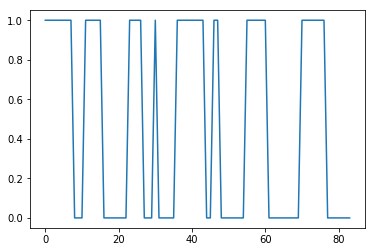

In [50]:
plt.plot(obs);

To build an autoregressive model, I use the observation at `t-1` as predictor for the observation at `t`

In [51]:
obs_t_minus_1 = obs[:-NUM_MISSING_DATAPOINTS].copy()
obs_t_minus_1

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

However, for the first observation I don't have the observation at the previous time step. Hence I will insert a missing observation (coded as `-1`)

In [52]:
obs_t_minus_1 = np.insert(obs_t_minus_1, 0, values=np.repeat(-1, NUM_MISSING_DATAPOINTS))
obs_t_minus_1

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0])

In [53]:
assert(obs_t_minus_1.shape == obs.shape)

I will use the numpy `masked_array` to deal with the missing observation. In this way I can predict what the value for that observation was via the Bayesian inference

In [54]:
import numpy.ma as ma

In [55]:
obs_t_minus_1_ma = ma.masked_where(obs_t_minus_1==-1, obs_t_minus_1)
obs_t_minus_1_ma

masked_array(data=[--, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
                   0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
                   0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
                   0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                   1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
             mask=[ True, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, Fals

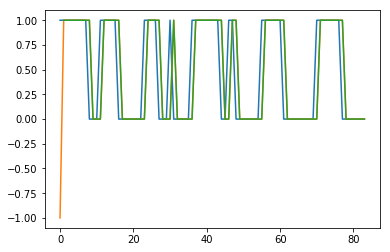

In [56]:
plt.plot(obs)
plt.plot(obs_t_minus_1)
plt.plot(obs_t_minus_1_ma) # the missing value is not plotted. That's good

In [57]:
with pm.Model() as model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    p_missing = pm.Beta('p_missing', alpha=2, beta=2)
    obs_t_minus_1_missing = pm.Bernoulli('obs_t_minus_1_missing', p=p_missing, observed=obs_t_minus_1_ma)
    
    p = pm.math.invlogit(alpha + pm.math.dot(beta, obs_t_minus_1_missing))
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=obs)
    
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=1, random_seed=SEED)

TypeError: Cannot convert Type TensorType(int64, vector) (of Variable obs_t_minus_1_missing_missing_shared__) into Type TensorType(int64, (True,)). You can try to manually convert obs_t_minus_1_missing_missing_shared__ into a TensorType(int64, (True,)).

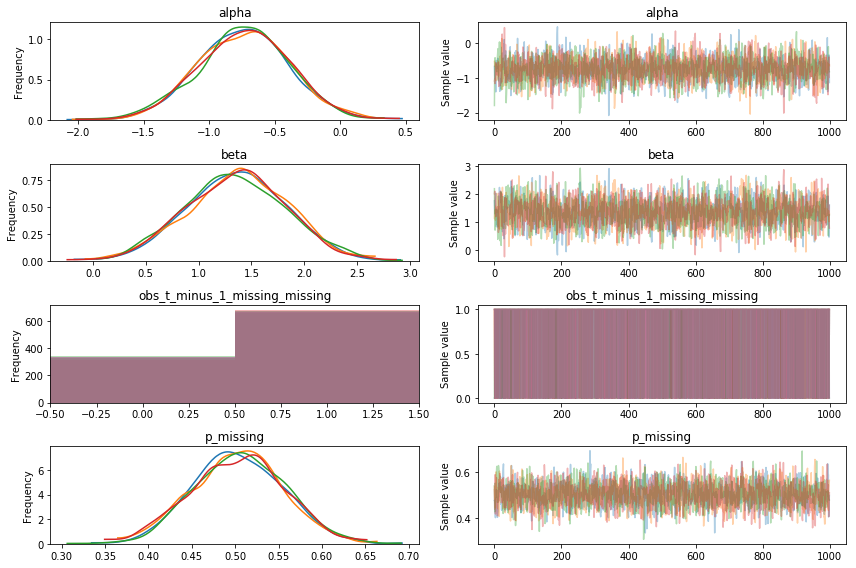

In [59]:
pm.traceplot(trace);

In [60]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.739760,0.344655,0.006126,-1.444646,-0.093528,2525.270830,0.999633
beta,1.354550,0.475275,0.008937,0.377021,2.216045,2497.658081,0.999817
obs_t_minus_1_missing_missing__0,0.663500,0.472512,0.006269,0.000000,1.000000,5279.020955,0.999516
obs_t_minus_1_missing_missing__1,0.674750,0.468468,0.005379,0.000000,1.000000,5754.470386,0.999613
p_missing,0.502931,0.052141,0.000975,0.400253,0.600256,2741.133287,1.000153


In the Agresti's book the results are $(\alpha, \beta) = (-1.609, 2.996)$